In [1]:
from google.colab import drive
# drive.flush_and_unmount()a
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.draw import rectangle_perimeter
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

# sys.path.append('/home/skong2/project/dpff4ldl')
# from utils.metrics import *
# from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.8.10 (default, Nov 14 2022, 12:59:47) 
[GCC 9.4.0]
1.13.1+cu116


In [4]:
# Here define the path, which is used to save the log and trained model in training process

project_name = '01_Generalized_Model_FullTrainingData'
trial = 'Trial_03'

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 20
weight_reg = 2.0
weight_background = 0.1

#model parameters
batch_size = 4
newSize = [1040,1392]
total_epoch_num = 30  # total number of epoch in training
base_lr = 0.0005      # base learning rate/
scaleList = [0]      # the number of output layer for U-net
#scale = [0,1,2,3]      # the number of output layer for U-net


exp_dir = '/content/gdrive/MyDrive/exp/' # experiment directory, used for reading the init model
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)

cuda:0


In [5]:
eval_dir = '/content/gdrive/MyDrive/eval/' 
eval_dir = os.path.join(eval_dir, project_name, trial) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

In [6]:
path_to_image = '/content/gdrive/Othercomputers/My MacBook Air/Training_Tiles3'
path_to_annotCombo = '/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask'
with open(os.path.join(save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 2389, 597)

In [7]:
################## init model ###################
path_to_save_paramOnly = path.join(save_dir, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

False


In [8]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image='/content/gdrive/Othercomputers/My MacBook Air/Training_Tiles3',
                 path_to_annot='/content/gdrive/MyDrive/UTRECHT/Detection/AnnotCombo9_noNPP_circleMask',
                 path_to_mask='/content/gdrive/MyDrive/UTRECHT/Detection/Masks9_noNPP_circleMask',
                 dbinfo=dbinfo,
                 size=[1040,1392], 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx] 

        current_image_path= os.path.join(self.path_to_image, current_example)
        current_distTransform_path=os.path.join(self.path_to_mask, current_example)
        curPickleName = path.join(self.path_to_annot, current_example)

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.bmp'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice))
            image = np.block(imagestack_array)
          if image.shape[2] <27:
            pad_val = 27-image.shape[2]
            npad = ((0, 0), (0,0), (0,pad_val))
            image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)

        for file in sorted(os.listdir(current_distTransform_path)):
          if file.endswith('.bmp'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.expand_dims(mask, axis=2)

        for file in sorted(os.listdir(curPickleName)):
          if file.endswith('.pkl'):
            with open(os.path.join(curPickleName, file), 'rb') as handle:
              annot = pickle.load(handle)

        times = np.random.randint(1)
        if times!=0:
            if times==1:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
                    annot['coord_peaks'][i][1] = y
                    annot['size'] = (annot['size'][1], annot['size'][0])                    
            elif times==2:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
            elif times==3:
                for i in range(annot['coord_peaks'].shape[0]):
                    y, x = annot['coord_peaks'][i]
                    annot['coord_peaks'][i][0] = x
                    annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
                    annot['size'] = (annot['size'][1], annot['size'][0])
            #for _ in range(times):
            image = np.rot90(image, times).copy()
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added       

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)
        labelOrgSize = F.interpolate(labelOrgSize, size=(self.size[0], self.size[1]), mode='nearest') # standardize original label size

        # mask_peaksOrgSize = labelOrgSize*0.    

        # mask_distanceTransformOrgSize  = mask_distanceTransform.copy().astype(np.float32)

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)/100.0/self.resizeFactor  # factor=size[0]/1000

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0) # self.TF2tensor(label)       
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) # self.TF2tensor(mask_distanceTransform)
        # mask_distanceTransformOrgSize = torch.from_numpy(mask_distanceTransformOrgSize).unsqueeze(0)

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        crop0 = image_label[0:800, 0:800,:]
        crop1 = image_label[0:800, width-800:,:]
        crop2 = image_label[height-800:, 0:800,:]
        crop3 = image_label[height-800:, width-800:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example
        # return image, label, mask_distanceTransform, mask_overlap, mask_voteX, mask_voteY, mask_peaks, mask_radius, labelOrgSize, mask_peaksOrgSize, mask_distanceTransformOrgSize, mask_radiusOrgSize

In [9]:
set_name = 'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              path_to_annot=path_to_annotCombo,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=False, 
                         num_workers=4) # num_work can be set to batch_size



# Define functions

In [10]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    # intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    removed = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)


        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                  bbox_list_thresholded.remove(box)
                  removed.append(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt, removed

In [12]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

# visualize outputs from small grain detector

In [13]:
# ################## init model ###################
# path_to_save_paramOnly = path.join(exp_dir, trial, 'bestValModel_encoder.paramOnly')

# curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
# curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
# curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
# curmodel.to(device);    
# #print(curmodel.state_dict)
# curmodel.eval()
# #curmodel.train()
# curmodel.training = False
# print(curmodel.training)

In [14]:
iterCount, sampleCount = 0, 0
phase = 'test'
for sample in dataloaders: 
    iterCount += 1     
      
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    if current_example[0] == 'PALIV_36-37_slide 1_scan1_109':
      curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)
      curImg_squeeze=torch.squeeze(curImg,0)

      sampleCount += curLabel.size(0)   
      
      outputs = curmodel(curImg_squeeze)
      predSeg = outputs[('segMask', 0)]
      predDistTransform = outputs[('output', 0)]

      softmax = predSeg
      break

    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

50/597
100/597
150/597
200/597


In [15]:
#PALIV_36-37_slide 1_scan1_35         Image with mel and fungal spore. mel not detected in general detector because predicted radius was too large.
# PALIV_36-37_slide 1_scan1_109       Image with cec. Good to use as an example, contains isoetes too.
# PALIV_B_Sample_34-35_glyc_scan3_264   Image with cec
# PALIV_B_Sample_34-35_glyc_scan2_153    Image with u/m
#PALIV_36-37_slide 1_scan1_230        aca   NOT in small grain test set.
#PALIV_B_Sample_33-34_glyc_scan1_395    aca

In [16]:
# sampler = iter(dataloaders)

In [17]:
# curImg, curLabel, curMask, curMask_orgSize, current_example = next(sampler)
# print(current_example)

# curImg = curImg.to(device)
# curImg_squeeze=torch.squeeze(curImg,0)

# outputs = curmodel(curImg_squeeze)
# predSeg = outputs[('segMask', 0)]
# predDistTransform = outputs[('output', 0)]

In [18]:
print(current_example[0])

PALIV_36-37_slide 1_scan1_109


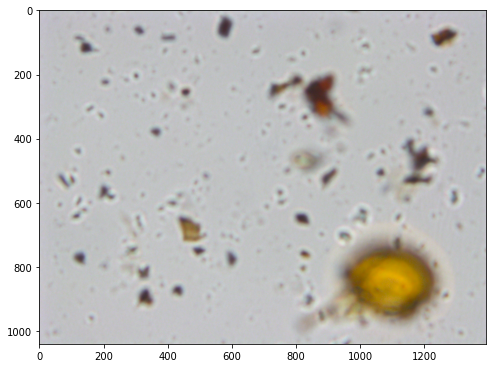

In [19]:
slice_path=[]
current_image_path= os.path.join(path_to_image, current_example[0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.bmp'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
img = mpimg.imread(slice_path[7]).copy()

plt.figure(figsize=(8,8)) # figsize -- inch-by-inch
plt.imshow(img)

In [20]:
softmax = predSeg
print(predSeg.max(),predSeg.min())

tensor(0.9393, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0.0008, device='cuda:0', grad_fn=<MinBackward1>)


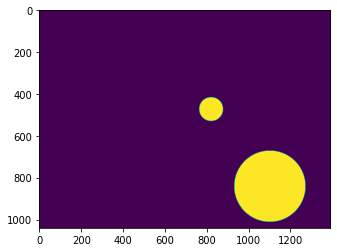

In [21]:
curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
curmask_OrgSize_binary = curmask_OrgSize >0.5
plt.imshow(curmask_OrgSize_binary)

In [22]:
# create a list of (800x800) prediction distance transforms crops and softmax crops

predDistTransform_crops=[]
softmax_crops = []

for idx in range(0,4):
  tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
  predDistTransform_crops.append(tmpImg)

for idx in range(0,4):
  tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
  softmax_crops.append(tmpImg)

In [23]:
# create full-sized pred distance transform 

mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
predDistTransform=np.zeros_like(mask_OrgSize)  
predDistTransform=predDistTransform.astype(np.float32)

tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


tmp_predDistTransform_1[0:800, 0:800]=predDistTransform_crops[0]
tmp_predDistTransform_2[0:800, width-800:]=predDistTransform_crops[1]
tmp_predDistTransform_3[height-800:, 0:800]=predDistTransform_crops[2]
tmp_predDistTransform_4[height-800:, width-800:]=predDistTransform_crops[3]

predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
predDistTransform = gaussian_filter(predDistTransform, sigma=3) # gaussian blur to get rid of shadow

In [79]:
# create full-sized softmax

# mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

height,width = mask_OrgSize.shape
softmax=np.zeros_like(mask_OrgSize)  
softmax=softmax.astype(np.float32)

tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

tmp_softmax_1[0:800, 0:800]=softmax_crops[0]
tmp_softmax_2[0:800, width-800:]=softmax_crops[1]
tmp_softmax_3[height-800:, 0:800]=softmax_crops[2]
tmp_softmax_4[height-800:, width-800:]=softmax_crops[3]

softmax = np.mean( np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0 )
# softmax = np.maximum.reduce( [tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4])

In [80]:
predBinaryMask = softmax>0.4
predBinaryMask=binary_opening(predBinaryMask,square(5))
predBinaryMask = dilation(predBinaryMask,square(10))

In [81]:
predSegMask = measure.label(predBinaryMask, background=0)

In [82]:
pred_distanceTransform = np.copy(predDistTransform)

voting4center = np.copy(pred_distanceTransform)
voting4center[voting4center<0.01] = 0 #changed from voting4center[voting4center<0.1]

In [83]:
coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

In [84]:
# create detection mask using peaks and predicted radius
# coord_peaks = feature.peak_local_max(voting4center, min_distance=25, exclude_border=False) #originally min_distance =5, changed to 25

centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
# predRadiusList2 = []
detection_info = []
detection_info2 = []
# detMask_info = []

size = (300,300)

# i=0

for i in range(coord_peaks.shape[0]):
    y, x = coord_peaks[i]
    centerMask[y-10:y+10, x-10:x+10] = 1

    left = int(x-(size[0]/2))
    left=max(left,0)
    top = int(y-(size[0]/2))
    top=max(top,0)
    right = int(x+(size[0]/2))
    right=max(right,0)
    bottom = int(y+(size[0]/2))
    bottom=max(bottom,0)

    tmpCrop = softmax[top:bottom, left:right]
    thresh = threshold_otsu(tmpCrop) 
    tmpCrop = tmpCrop> thresh # binarize
    tmpCrop= measure.label(tmpCrop, background=0)
    props = measure.regionprops(tmpCrop) #get the properties of the connected components

    # diameter = [prop.feret_diameter_max for prop in props]
    # diameter = [prop.equivalent_diameter for prop in props]  #diameter for connected components
    diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
    radius = int(max(diameter)/2)

    predRadiusList += [radius]

    #write bb coords to file
    # bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components

    class_name="det"
    leftBb = x-radius
    leftBb = max(leftBb,0)
    topBb = y-radius
    topBb= max(topBb,0)
    rightBb = x+radius
    rightBb = max(rightBb, 0)
    bottomBb = y+radius
    bottomBb = max(bottomBb,0)

    # get confidence using softmax
    tmpMask = voting4center*0
    tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[i], value=1)

    masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
    confidence = np.nanmean(masked_softmax)
    confidence = confidence
    # bbox_info = [class_name,str(confidence) , str(leftBb), str(topBb), str(rightBb), str(bottomBb)]
    bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]
    # circle_info = [y,x,radius]

    # if confidence <0.05:
    #     continue
    # else:
    # detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)
    # bbox_info = ' '.join(bbox_info)
    # detection_info.append(bbox_info)
    detection_info2.append(bbox_info2)
    # detMask_info.append(circle_info)

# Apply non-max suppression
NMS_bb = nms(detection_info2,conf_threshold=0, iou_threshold=0.3)
NMS_bb = NMS_bb[0]

# print(predRadiusList)
# print(detection_info)
# print(detection_info2)
print(NMS_bb)

[['det', 0.25839257, 966, 733, 1206, 973], ['det', 0.012437567, 815, 243, 943, 371]]


In [85]:
detMask = voting4center*0
det_info = []

for i in range(len(NMS_bb)):
    confidence = float(NMS_bb[i][1])
    leftBb = int(NMS_bb[i][2])
    topBb = int(NMS_bb[i][3])
    rightBb = int(NMS_bb[i][4])
    bottomBb = int(NMS_bb[i][5])
    diameter = max(rightBb - leftBb, bottomBb - topBb)
    radius = diameter/2
    x = leftBb + radius
    y = topBb +  radius
    det_info.append([y, x, radius])

for i in range(len(det_info)):
  y = det_info[i][0]
  x = det_info[i][1]
  radius = det_info[i][2]
  detMask = create_circular_mask(detMask, [y, x], radius, value=i+1)

In [86]:
current_image_path= os.path.join(path_to_image, current_example[0])
path_to_imdb = os.path.join(str(current_image_path), 'annot.csv')
imdb = pd.read_csv(path_to_imdb, dtype=object)

class_label_coord = pd.DataFrame(imdb, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height'])
class_label_coord = class_label_coord.values.tolist()

class_labels=pd.DataFrame(imdb, columns=['Code', 'Family','Genus','Species'])
print(class_labels)

class_labels= class_labels.values.tolist()

  Code      Family     Genus Species
0  iso  isoetaceae   isoetes       -
1  cec    moraceae  cecropia       -


In [88]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(15,15), dpi = 300, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
slice_path=[]
current_image_path= os.path.join(path_to_image, current_example[0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.bmp'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
tmpImg = mpimg.imread(slice_path[4]).copy()
tmpImg_1 = tmpImg.copy()
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'Image.png'), tmpImg, format='png')
for idx in range(len(class_label_coord)):
    # if idx == 0 or idx == 3: 
    #     continue
    x = int(class_label_coord[idx][0])
    y = int(class_label_coord[idx][1])
    H = int(class_label_coord[idx][2])
    W = int(class_label_coord[idx][3])
    start = (y, x)
    end = (y+H, x+W)
    rr, cc = rectangle_perimeter(start, end=end, shape=tmpImg.shape)
    tmpImg[rr, cc] = 1
    plt.text(x, y+50, class_labels[idx][0],
             fontsize=10,
             color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])

plt.imshow(tmpImg)
plt.title('image-w-original-label')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'Image_wTags.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_OrgSize
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'dist-transform-grnd.png'), tmpImg, format='png')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = (softmax-np.min(softmax))/(np.max(softmax)-np.min(softmax))
plt.imshow(tmpImg)
plt.title('pred-softmax')
plt.colorbar()
plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Exp1_SmallGrain_Comparison_Images',current_example[0],'pred-softmax_mean.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = pred_distanceTransform*100
tmpImg = ((tmpImg - tmpImg.min()) * (1/(tmpImg.max() - tmpImg.min()) * np.max(mask_OrgSize)))
plt.imshow(tmpImg)
plt.title('dist-transform-pred')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'pred-distTransform.png'), tmpImg, format='png')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = centerMask
plt.imshow(tmpImg)
plt.title('centerMask')
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'centerMask.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
masked = np.ma.masked_where(detMask == 0, detMask)
plt.imshow(tmpImg_1, interpolation='none')
plt.imshow(masked, 'viridis', interpolation='none', alpha=0.5)    #'jet' also works as color
plt.title('detMask-overlay')
for idx in range(len(NMS_bb)):
    x = int(NMS_bb[idx][2])
    y = int(NMS_bb[idx][3])
    plt.text(x, y+50,round(NMS_bb[idx][1],4),
             fontsize=10,
             color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
# plt.imsave(os.path.join('/content/gdrive/MyDrive/Figures/Jan 2023',current_example[0],'detMask-overlay.png'), masked, format='png')